In [1]:
# general imports
import random
import numpy as np
import math
import os
import time
import sys

# external files
import level_gen_sql
import pair_gen_sql
import pair_EXT_gen_sql
import aesthetic_bot
import TPKLDiv
import utils


%matplotlib inline

#### Import the models

In [71]:
# global variables
TILENAMES = ["zelda","pokemon","pacman","amongus","dungeon"]
# get the tilesets
TILESETS = {}
for t in TILENAMES:
    TILESETS[t] = level_gen_sql.Tileset(t)

# import the models (multiple times for training comparisons)
BASE_CNN_DIR = "cnn_models/9b"
AESTH_BOT_CNN = {}
    
# get the fitness CNN bots - separated by stage of training
for stage in ["untrained", "pretrained", "2 weeks", "current"]:
    AESTH_BOT_CNN[stage] = {}

    for t in TILENAMES:
        botCNN = aesthetic_bot.FitnessCNN(TILESETS[t],"binary")
        if stage != "untrained":
#             if stage == "pretrained": #use the very first one
#                 botCNN = aesthetic_bot.FitnessCNN(TILESETS[t],"whole")
#                 botCNN.importModel("cnn_models/6",t)
#             else:
            botCNN.importModel(BASE_CNN_DIR,t)
        AESTH_BOT_CNN[stage][t] = botCNN

#### Import the pairings

In [72]:
#1 import the pairings
MIN_VOTE_REQ = 10

# 1a. get all of the pairings saved to the database
all_pairIDs = pair_gen_sql.getAllPairIDs()
pairDataSet = {}

for pid in all_pairIDs:
    vr = pair_gen_sql.pair2Rating(pid)

    # pair not found
    if vr == None:
        print(f"** No valid pairing found for ID [ {pid} ] **")
        continue

    total = (abs(vr['real']['votes']) + abs(vr['fake']['votes']))
    # not enough votes
    if total < MIN_VOTE_REQ:
        print(f"** Not enough votes for ID [ {pid} ] ({total} < {MIN_VOTE_REQ})")        
        continue
    pairDataSet[str(pid)] = vr
    
# 1b. get all of the pairings saved to the database (EXT)
all_pairEXTIDs = pair_EXT_gen_sql.getAllPairIDs()
for pid in all_pairEXTIDs:
    vr = pair_EXT_gen_sql.pair2Rating(pid)

    # pair not found
    if vr == None:
        print(f"** No valid pairing found in [EXT] for ID [ {pid} ] **")
        continue

    total = (abs(vr['real']['votes']) + abs(vr['fake']['votes']))
    # not enough votes
    if total < MIN_VOTE_REQ:
        print(f"** Not enough votes for ID [ {pid} ] ({total} < {MIN_VOTE_REQ})")
        continue
    pairDataSet[f"{pid}_ext"] = vr

** Not enough votes for ID [ 53 ] (1 < 10)
** Not enough votes for ID [ 55 ] (1 < 10)
** Not enough votes for ID [ 56 ] (1 < 10)
** Not enough votes for ID [ 57 ] (1 < 10)
** Not enough votes for ID [ 58 ] (0 < 10)
** Not enough votes for ID [ 70 ] (1 < 10)
** Not enough votes for ID [ 71 ] (1 < 10)
** Not enough votes for ID [ 72 ] (0 < 10)
** Not enough votes for ID [ 74 ] (0 < 10)
** Not enough votes for ID [ 76 ] (1 < 10)
** Not enough votes for ID [ 77 ] (0 < 10)
** Not enough votes for ID [ 78 ] (0 < 10)
** Not enough votes for ID [ 79 ] (0 < 10)
** Not enough votes for ID [ 80 ] (0 < 10)
** Not enough votes for ID [ 81 ] (1 < 10)
** Not enough votes for ID [ 82 ] (0 < 10)
** Not enough votes for ID [ 83 ] (0 < 10)
** Not enough votes for ID [ 84 ] (0 < 10)
** Not enough votes for ID [ 85 ] (1 < 10)
** Not enough votes for ID [ 86 ] (0 < 10)
** Not enough votes for ID [ 87 ] (1 < 10)
** Not enough votes for ID [ 90 ] (0 < 10)
** Not enough votes for ID [ 91 ] (0 < 10)
** Not enou

In [73]:
#1c. sort pairings by time (found by id)
MAX_ID = 203  #may 12th
pair2Weeks = []
pairAll = []
for k,v in pairDataSet.items():
    # all extended pairings are after May 12th
    if "ext" in k:
        pairAll.append(v)
        
    # rest may be before may 12th
    else:
        pairAll.append(v)
        if int(k) <= MAX_ID:
            pair2Weeks.append(v)
            
random.shuffle(pairAll[:40])
            
print(f"# 2 week pairings: {len(pair2Weeks)}")
print(f"# current pairings: {len(pairAll)}")

pairStageSet = {}
pairStageSet["2 weeks"] = pair2Weeks
pairStageSet["current"] = pairAll

# 2 week pairings: 95
# current pairings: 219


#### train on incremental pairings

In [74]:
# 2. create level/score sets by tile
stageTrain = {}
for stage in ["2 weeks", "current"]:
    stageTrain[stage] = {}
    map_set = {}
    score_set = {}
    for t in TILENAMES:
        stageTrain[stage][t] = []
        map_set[t] = {'real':[], 'fake':[]}
        score_set[t] = {'real':[], 'fake':[]}
    for pair_data in pairStageSet[stage]:
        TILE = pair_data['tileset']

        total = max((abs(pair_data['real']['votes']) + abs(pair_data['fake']['votes'])), 1)
        real_score = pair_data['real']['votes'] / total
        fake_score = pair_data['fake']['votes'] / total
        
        #take previous set and concatenate on
        map_set[TILE]['real'].append(pair_data['real']['level'])
        map_set[TILE]['fake'].append(pair_data['fake']['level'])
        score_set[TILE]['real'].append(real_score)
        score_set[TILE]['fake'].append(fake_score)
        
        tt_set = {'map':{},'score':{}}
        tt_set['map']['real'] = map_set[TILE]['real'][:]
        tt_set['map']['fake'] = map_set[TILE]['fake'][:]
        tt_set['score']['real'] = score_set[TILE]['real'][:]
        tt_set['score']['fake'] = score_set[TILE]['fake'][:]
        
        
        stageTrain[stage][TILE].append(tt_set)  
        
# sanity check (should increase by 1 every time)
# for tt in stageTrain["2 weeks"]["amongus"]:
#     print(len(tt['score']['real']))

# 3. train on the ratings
for stage in ["2 weeks", "current"]:
    print("")
    print(f" --- stage : {stage} ---")
    for t in TILENAMES: 
        print(f"> {t}")
        # train
        for tt in stageTrain[stage][t]:
            _, _ = AESTH_BOT_CNN[stage][t].train(10, tt['map'], tt['score'])


 --- stage : 2 weeks ---
> zelda
# real:9 / # fake:9 => 9
# real:25 / # fake:18 => 25
# real:74 / # fake:27 => 74
# real:123 / # fake:36 => 123
# real:172 / # fake:52 => 172
# real:181 / # fake:61 => 181
# real:197 / # fake:70 => 197
# real:246 / # fake:86 => 246
# real:295 / # fake:102 => 295
# real:344 / # fake:111 => 344
# real:393 / # fake:120 => 393
# real:442 / # fake:129 => 442
# real:478 / # fake:138 => 478
# real:503 / # fake:147 => 503
# real:552 / # fake:163 => 552
# real:601 / # fake:172 => 601
# real:650 / # fake:181 => 650
# real:699 / # fake:217 => 699
# real:748 / # fake:253 => 748
# real:797 / # fake:262 => 797
# real:846 / # fake:278 => 846
# real:895 / # fake:303 => 895
# real:976 / # fake:312 => 976
# real:1057 / # fake:321 => 1057
# real:1106 / # fake:337 => 1106
# real:1155 / # fake:362 => 1155
# real:1204 / # fake:387 => 1204
> pokemon
# real:36 / # fake:25 => 36
# real:85 / # fake:61 => 85
# real:134 / # fake:70 => 134
# real:183 / # fake:79 => 183
# real:232 /

# real:845 / # fake:350 => 845
# real:894 / # fake:399 => 894
> dungeon
# real:9 / # fake:36 => 36
# real:58 / # fake:72 => 72
# real:74 / # fake:88 => 88
# real:123 / # fake:124 => 124
# real:172 / # fake:160 => 172
# real:188 / # fake:196 => 196
# real:237 / # fake:232 => 237
# real:286 / # fake:257 => 286
# real:335 / # fake:266 => 335
# real:384 / # fake:275 => 384
# real:433 / # fake:284 => 433
# real:482 / # fake:293 => 482
# real:531 / # fake:302 => 531
# real:580 / # fake:311 => 580
# real:629 / # fake:327 => 629
# real:710 / # fake:336 => 710
# real:759 / # fake:345 => 759
# real:840 / # fake:354 => 840
# real:889 / # fake:363 => 889
# real:970 / # fake:372 => 970
# real:1019 / # fake:381 => 1019
# real:1083 / # fake:390 => 1083
# real:1132 / # fake:399 => 1132
# real:1181 / # fake:408 => 1181
# real:1190 / # fake:417 => 1190
# real:1239 / # fake:426 => 1239
# real:1320 / # fake:435 => 1320
# real:1401 / # fake:451 => 1401
# real:1450 / # fake:460 => 1450
# real:1466 / # fake:

#### Test validation

In [75]:
NUM_MAPS = 5

# get random levels
random_set = {}
for TILE in TILENAMES:
    random_set[TILE] = utils.makeRandomAscMaps(NUM_MAPS)

    
# get already evaluated maps
eval_set = {}
for TILE in TILENAMES:
    eval_set[TILE] = {'maps':[], 'scores':[]}
    last_set = stageTrain[stage][TILE][-1]
    rand_set_ind = random.sample(range(len(last_set['map']['real'])),k=NUM_MAPS)
    for i in rand_set_ind:
        eval_set[TILE]['maps'].append(last_set['map']['real'][i])
        eval_set[TILE]['scores'].append(last_set['score']['real'][i])
    

#get unevaluated user maps (assume counts as NUM_MAPS)
user_set = {}
for TILE in TILENAMES:
    user_set[TILE] = []
USER_SEL_IDS = [459,453,417,415,372,395,448,446,440,427,420,437,385,400,342,313,369,305,318,461,429,306,386,390,444]  #select these user levels in particular
for i in USER_SEL_IDS:
    sql_level = level_gen_sql.SQLLevel()
    sql_level.importSQLLevel("user",i)
    tile = sql_level.dat['tileName']
    user_set[tile].append(sql_level.ascii_level.level)
    

print("RANDOM")
for TILE in TILENAMES:
    utils.showMultiMaps(random_set[TILE],TILE)
    
print("EVALUATED")
for TILE in TILENAMES:
    utils.showMultiMaps(eval_set[TILE]['maps'],TILE,'',eval_set[TILE]['scores'])
    
print("VALIDATION")
for TILE in TILENAMES:
    utils.showMultiMaps(user_set[TILE],TILE)


RANDOM
EVALUATED
VALIDATION


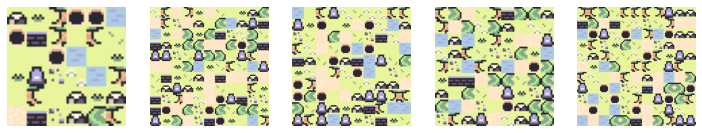

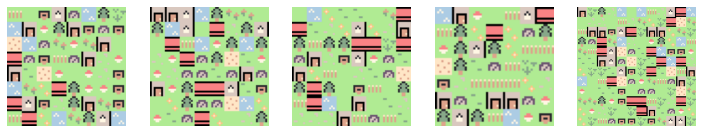

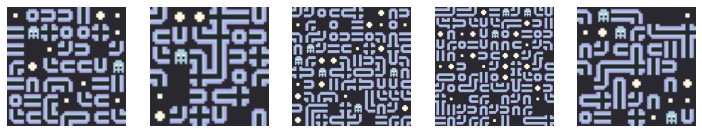

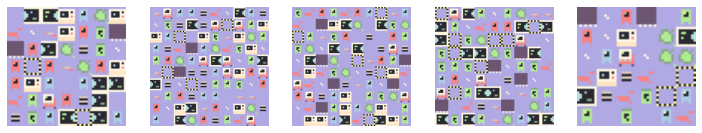

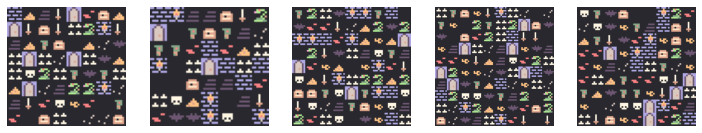

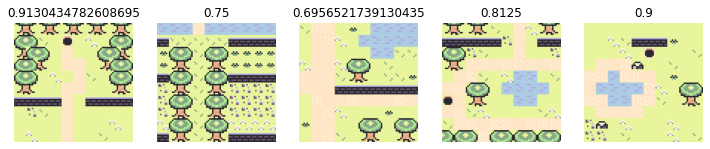

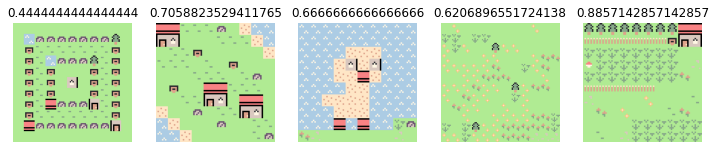

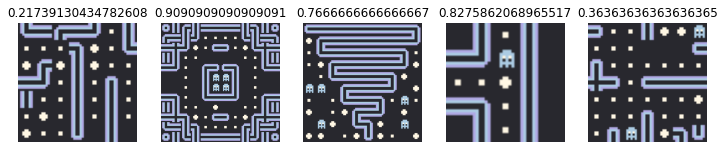

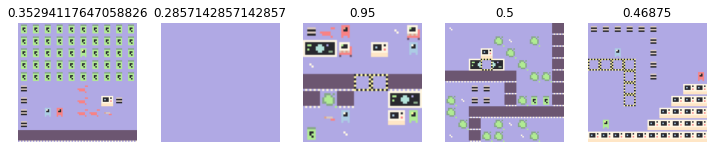

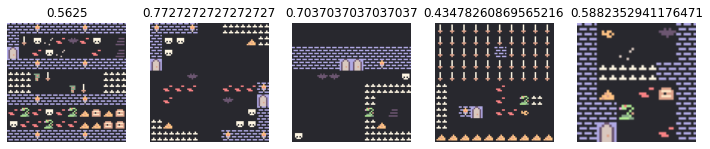

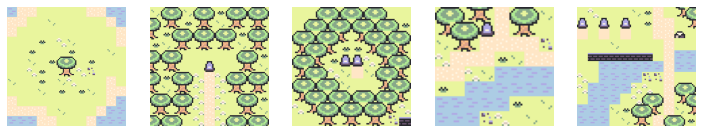

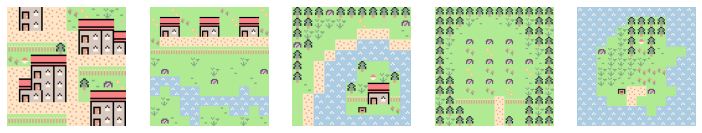

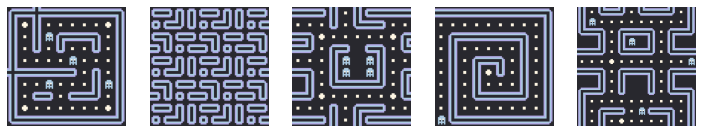

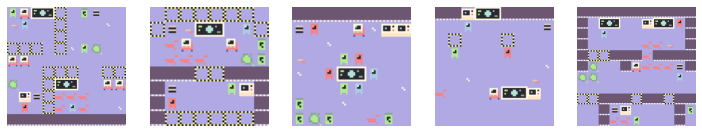

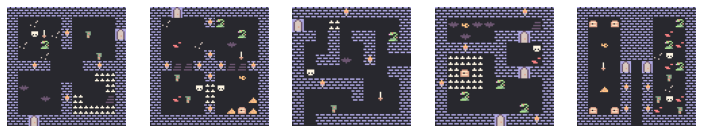

In [83]:
#TEST OUTPUT

print("RANDOM")
for TILE in TILENAMES:
    utils.showMultiMaps(random_set[TILE],TILE)
    
print("EVALUATED")
for TILE in TILENAMES:
    utils.showMultiMaps(eval_set[TILE]['maps'],TILE,'',eval_set[TILE]['scores'])
    
print("VALIDATION (GOOD)")
for TILE in TILENAMES:
    utils.showMultiMaps(good_user_set[TILE],TILE)
        
print("VALIDATION (BAD)")
for TILE in TILENAMES:
    utils.showMultiMaps(bad_user_set[TILE],TILE)

In [86]:
# run models on all
datset = {"random":random_set,"test":user_set,"train (% err)":eval_set}
mod_pred = {}

for TILE in TILENAMES:
    mod_pred[TILE] = {}
    for stage in ["untrained", "pretrained", "2 weeks", "current"]:
        aesbot = AESTH_BOT_CNN[stage][TILE]
        mod_pred[TILE][stage] = {}
        for k,v in datset.items():
            print(f"> {TILE} : {stage} : {k}")
            if k == 'train (% err)':
                m = v[TILE]['maps']
            else:
                m = v[TILE]
                
            #mod_pred[TILE][stage][k] = [f"{x:.2f}" for x in aesbot.eval_map_population(m)]  #get prediction from the network
            if k == "train (% err)":
                p = aesbot.eval_map_population(m)
                e = []
                for i in range(len(p)):
                    actual = v[TILE]['scores'][i]
                    c = abs(p[i]-actual)/actual
                    e.append(c)
                mod_pred[TILE][stage][k] = np.average(e)
            else:
                mod_pred[TILE][stage][k] = np.average(aesbot.eval_map_population(m))
            

> zelda : untrained : random
> zelda : untrained : test
> zelda : untrained : train (% err)
> zelda : pretrained : random
> zelda : pretrained : test
> zelda : pretrained : train (% err)
> zelda : 2 weeks : random
> zelda : 2 weeks : test
> zelda : 2 weeks : train (% err)
> zelda : current : random
> zelda : current : test
> zelda : current : train (% err)
> pokemon : untrained : random
> pokemon : untrained : test
> pokemon : untrained : train (% err)
> pokemon : pretrained : random
> pokemon : pretrained : test
> pokemon : pretrained : train (% err)
> pokemon : 2 weeks : random
> pokemon : 2 weeks : test
> pokemon : 2 weeks : train (% err)
> pokemon : current : random
> pokemon : current : test
> pokemon : current : train (% err)
> pacman : untrained : random
> pacman : untrained : test
> pacman : untrained : train (% err)
> pacman : pretrained : random
> pacman : pretrained : test
> pacman : pretrained : train (% err)
> pacman : 2 weeks : random
> pacman : 2 weeks : test
> pacman : 

In [87]:
import pandas as pd

for TILE in TILENAMES:
    dat = mod_pred[TILE]
    print(f"--- {TILE.upper()} ---")
    print(pd.DataFrame.from_dict(dat))
    print("")

--- ZELDA ---
               untrained  pretrained   2 weeks   current
random          0.494862    0.271017  0.229718  0.235815
test            0.495993    0.516341  0.665135  0.661552
train (% err)   0.383926    0.152219  0.143502  0.029274

--- POKEMON ---
               untrained  pretrained   2 weeks   current
random          0.495460    0.218103  0.152768  0.216971
test            0.495297    0.560736  0.679235  0.624301
train (% err)   0.262343    0.091955  0.147149  0.019378

--- PACMAN ---
               untrained  pretrained   2 weeks   current
random          0.495028    0.135620  0.492546  0.347246
test            0.494553    0.522748  0.672363  0.737013
train (% err)   0.571901    0.506679  0.612047  0.366948

--- AMONGUS ---
               untrained  pretrained   2 weeks   current
random          0.484094    0.295376  0.325415  0.315264
test            0.484330    0.410406  0.382965  0.478384
train (% err)   0.333598    0.255976  0.083314  0.029296

--- DUNGEON ---
       